In [ ]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Install BNN using pytorch library
!pip install torchbnn

In [ ]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
import torchbnn as bnn
from scipy import stats

In [ ]:
# Load the data
fatigue_df = pd.read_csv("/content/drive/MyDrive/Datasets/Titanium_Alloy_PI.csv", encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,N,O,H,Fe,Si,Sn,Nb,Mo,Zr,PI Fatigue Life
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0,1.199845e+05
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0,1.414165e+05
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0,3.316557e+05
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0,4.734918e+05
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0,2.211821e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,1.801202e+02
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,2.168016e+02
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,2.488141e+02
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,3.426198e+02


In [ ]:
fatigue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

In [ ]:
# Sort the data by ascending order of number of cycles
fatigue_df = fatigue_df.sort_values(by='Number of Cycles')

In [ ]:
from scipy import stats
def outliers(df1, level):

    # 1. temporary dataframe
    df = df1.copy(deep = True)

    # 2. Select a level for a Z-score to identify and remove outliers
    df_Z = df[(np.abs(stats.zscore(df)) < level).all(axis=1)]
    ix_keep = df_Z.index

    # 3. Subset the raw dataframe with the indexes you'd like to keep
    df_keep = df.loc[ix_keep]

    return(df_keep)

In [ ]:
# Removing Outliers
out_df = outliers(fatigue_df, 3)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number']

# Use all remaining columns as features
features = out_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(out_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,N,O,H,Fe,Si,Sn,Nb,Mo,Zr,PI Fatigue Life
184,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.0025,0.00,0.004,0.0,0.340,4.00,0.70,0.500,3.70,1.428483e+02
79,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,1.331221e+02
80,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,2.796968e+02
84,725.00,1025,2.0,375,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,6.140270e+01
81,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,7.944426e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,703.00,0,0.0,25,600,8.0,0.00,0.1,0.0,85.98,...,0.0040,0.03,0.008,0.0,0.000,1.95,0.00,2.000,3.80,2.137039e+07
42,947.76,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,2.925415e+07
43,846.12,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,5.087448e+07
39,695.53,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,2.273788e+07


In [ ]:
features.head()

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,N,O,H,Fe,Si,Sn,Nb,Mo,Zr,PI Fatigue Life
184,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.0025,0.00,0.004,0.0,0.340,4.00,0.70,0.500,3.70,142.848275
79,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,133.122051
80,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,279.696801
84,725.00,1025,2.0,375,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,61.402704
81,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,79.444256


In [ ]:
# Resetting the index to default.
features = features.reset_index(drop=True)

Run # 1 Fold # 1
MSE : 18.91, KL : 0.63
MSE : 0.24, KL : 0.79
MSE : 0.16, KL : 0.85
Pearson CC: 0.9525857369541383
R2 score: 0.9034509989834758
RMSE: 0.5039423704147339
MAE: 0.3750946819782257
********************
Coverage: 62.16216216216216
Interval Width: 0.8134422302246094
Composite Metric: 0.7735521163095387


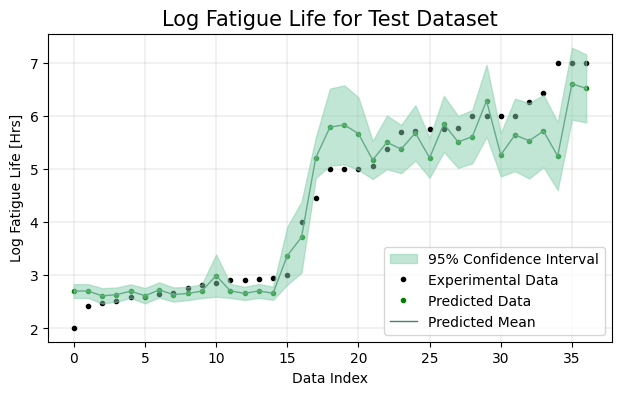

****************************************
Run # 1 Fold # 2
MSE : 19.38, KL : 0.63
MSE : 0.28, KL : 0.81
MSE : 0.28, KL : 0.88
Pearson CC: 0.96450519413421
R2 score: 0.9223047175206393
RMSE: 0.4540233314037323
MAE: 0.3252546489238739
********************
Coverage: 45.945945945945944
Interval Width: 0.25461673736572266
Composite Metric: 1.3264624897946995


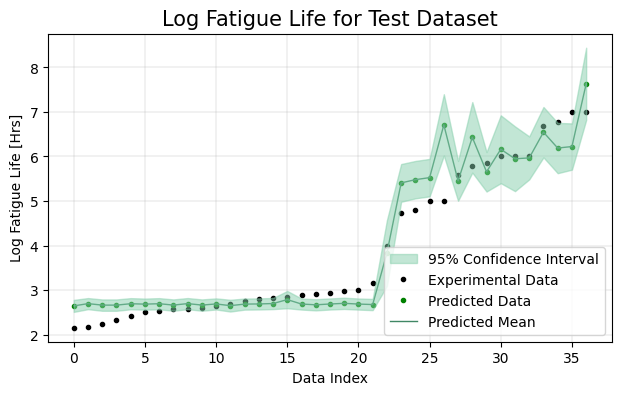

****************************************
Run # 1 Fold # 3
MSE : 15.96, KL : 0.63
MSE : 0.14, KL : 0.81
MSE : 0.29, KL : 0.87
Pearson CC: 0.977142462022615
R2 score: 0.9421656114867987
RMSE: 0.447632372379303
MAE: 0.3391566872596741
********************
Coverage: 56.75675675675675
Interval Width: 0.2663092613220215
Composite Metric: 1.3644338651541095


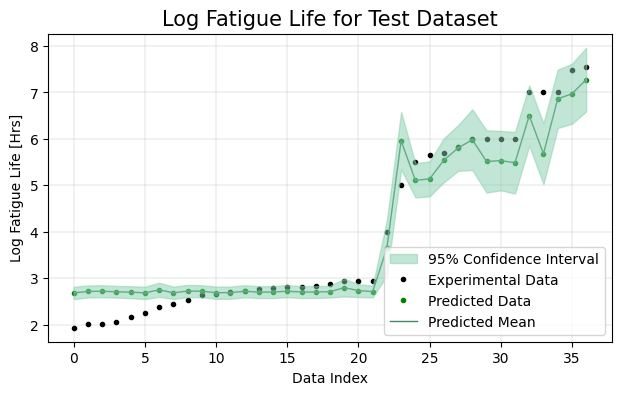

****************************************
Run # 1 Fold # 4
MSE : 21.11, KL : 0.64
MSE : 0.08, KL : 0.81
MSE : 0.11, KL : 0.87
Pearson CC: 0.9702667926879153
R2 score: 0.9246303894996096
RMSE: 0.4685576260089874
MAE: 0.3506288230419159
********************
Coverage: 51.35135135135135
Interval Width: 0.34064817428588867
Composite Metric: 1.119030159008616


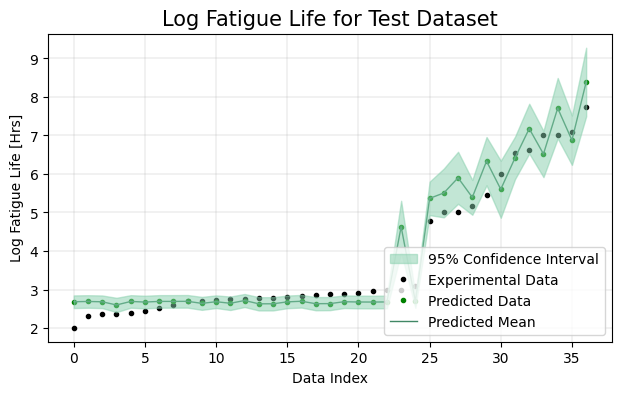

****************************************
Run # 1 Fold # 5
MSE : 27.18, KL : 0.63
MSE : 0.14, KL : 0.81
MSE : 0.14, KL : 0.87
Pearson CC: 0.9613052183908599
R2 score: 0.9217304498661699
RMSE: 0.4831696152687073
MAE: 0.36876508593559265
********************
Coverage: 48.648648648648646
Interval Width: 0.6691808700561523
Composite Metric: 0.7384559389477536


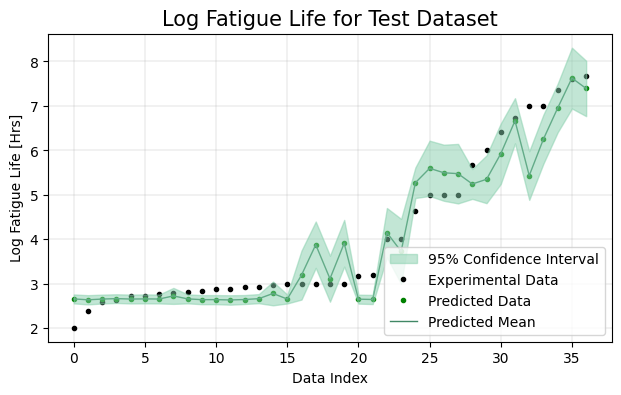

****************************************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)


test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)
            targets = targets.reset_index(drop=True)


            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)
            y_train = torch.unsqueeze(y_train, dim=1)
            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)
            y_test = torch.unsqueeze(y_test, dim=1)

            # create pytorch dataset class
            class MyDataset(Dataset):
                def __init__(self, train_data, train_targets):
                    self.train_features = train_data
                    self.train_labels = train_targets

                def __len__(self):
                    return self.train_features.shape[0]

                def __getitem__(self, idx):
                    feature = self.train_features[idx]
                    label = self.train_labels[idx]
                    return feature, label

            train_dataset = train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
            model = nn.Sequential(
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=23, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=1),
            )

            # define the loss function and optimizer
            mse_loss = nn.MSELoss()
            kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
            kl_weight = 0.01

            optimizer = optim.SGD(model.parameters(), lr=0.001, nesterov=True, momentum=0.95)
            for step in range(3000):
                  for n, data in enumerate(train_dataloader):
                        traning_data, training_label = data
                        y_pred = model(traning_data)
                        mse = mse_loss(y_pred, training_label)
                        kl = kl_loss(model)
                        cost = mse + kl_weight*kl

                        optimizer.zero_grad()
                        cost.backward()
                        optimizer.step()

                  if step % 1000==0:
                        print('MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))
            y_pred_test = model(x_test)

            # inference
            n_samples = 1000

            # compute predictions
            y_preds = [model(x_test).clone().detach().numpy() for _ in range(n_samples)]
            y_preds = np.array(y_preds)
            # mean and standard deviation
            y_pred = np.mean(y_preds, axis=0)
            y_std = np.std(y_preds, axis=0)
            y_test = y_test.detach().numpy()

            ## Metrics for evaluating the predictive accuracy of the model

            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(20*'*')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)

            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.squeeze(y_pred) - 2*np.squeeze(y_std), np.squeeze(y_pred) + 2*np.squeeze(y_std), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.squeeze(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Fatigue Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Fatigue Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

            print(40*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.952586,0.903451,0.503942,0.375095
1,0.964505,0.922305,0.454023,0.325255
2,0.977142,0.942166,0.447632,0.339157
3,0.970267,0.924630,0.468558,0.350629
4,0.961305,0.921730,0.483170,0.368765


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.965161,0.008283,0.922856,0.012281,0.471465,0.020359,0.35178,0.018419


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,62.162162,0.813442,0.773552
1,45.945946,0.254617,1.326462
2,56.756757,0.266309,1.364434
3,51.351351,0.340648,1.119030
4,48.648649,0.669181,0.738456


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,52.972973,5.8218,0.468839,0.229011,1.064387,0.265523


In [ ]:
fin_df = pd.concat([df2, df4], axis=1)

In [ ]:
fin_df

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,0.965161,0.008283,0.922856,0.012281,0.471465,0.020359,0.35178,0.018419,52.972973,5.8218,0.468839,0.229011,1.064387,0.265523
